# Ridge Regression Simulation
*This notebook compares the performance of different forms of ridge regression on simulated regression problems.*

## Import Dependencies

In [1]:
import numpy as np
import scipy
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup Simulation Parameters

In [2]:
np.random.seed(1)

p = 3
beta = np.array([0.001, 0.1, 10.0])
feature_sigma = 1.0
sigma = 1.0
train_sizes = list(range(8, 21))
N = 5000

## Generate Random Simulation Data

In [3]:
def generate_feature_matrix(n):
    return np.random.normal(scale=feature_sigma, size=(n, p))

def generate_target_vector(X):
    y_base = np.dot(X, beta)
    return y_base + np.random.normal(scale=sigma, size=X.shape[0])

def generate_simulation_data(n):
    X_train = generate_feature_matrix(n)
    y_train = generate_target_vector(X_train)
    X_test = generate_feature_matrix(1)
    y_test = generate_target_vector(X_test)
    return (X_train, y_train, X_test, y_test)

trial_index = 0
simulation_data = []
for n in train_sizes:
    trials = []
    for _ in range(N):
        trials.append((trial_index, generate_simulation_data(n)))
        trial_index += 1
    simulation_data.append(trials)

## Load pre-fitted ridge regresson parameters
A second order optimizer was used to fit ridge regression to the generated regression problems so as to minize the LOOCV for 1 and p regularization parameters.

Note: These values are specific to the simulation parameters and the value used to seed the random number generator.

In [4]:
rr1_params = np.loadtxt('loocv-simulation-rr1-params.txt')
rrp_params = np.loadtxt('loocv-simulation-rrp-params.txt')

## Verify the Ridge Regression Parameters Represent LOOCV Optimums
For each trial, we verify that the loaded ridge regression parameters supply a minimum of the LOOCV error on the training data by walking to neighboring parameters and confirming that we don't find one that's significantly better.

In [5]:
def compute_loocv(X, y, D):
    A = np.dot(X.T, X) + D
    A_inv = np.linalg.inv(A)
    b_hat = np.dot(A_inv, np.dot(X.T, y))
    y_hat = np.dot(X, b_hat)
    h = np.array([np.dot(x_i, np.dot(A_inv, x_i)) for x_i in X])
    return np.sum(((y - y_hat) / (1 - h))**2)

def verify_loocv_opt_1(X, y, alpha):
    """Verifies that a given single ridge regression regularization is a LOOCV optimum"""
    delta_x = 1.0e-3
    def f(x):
        return compute_loocv(X, y, np.identity(X.shape[1])*x)
    f0 = f(alpha)
    for x in [alpha-delta_x, alpha+delta_x]:
        x = np.abs(x)
        delta_y = f(x) - f0
        relative_delta_y = delta_y / delta_x
        if relative_delta_y < 0 and np.abs(relative_delta_y) > 1.0e-3:
            assert False, "can't verify optimum"

def verify_loocv_opt_p(X, y, alpha):
    """Verifies that a given multi ridge regression regularization is a LOOCV optimum"""
    delta_x = 1.0e-3
    for i, alpha_i in enumerate(alpha):
        def f(x):
            alpha_copy = np.array(alpha)
            alpha_copy[i] = x
            return compute_loocv(X, y, np.diag(alpha_copy))
        f0 = f(alpha_i)
        for x in [alpha_i - delta_x, alpha_i + delta_x]:
            x = np.abs(x)
            delta_y = f(x) - f0
            relative_delta_y = delta_y / delta_x
            if relative_delta_y < 0 and np.abs(relative_delta_y) > 1.0e-3:
                assert False, "can't verify optimum"
                
for trial_data in simulation_data:
    for trial_index, (X_train, y_train, _, _) in trial_data:
        verify_loocv_opt_1(X_train, y_train, rr1_params[trial_index])
        verify_loocv_opt_p(X_train, y_train, rrp_params[trial_index])

## Fit Ridge Regression

In [6]:
def fit_ridge_regression(X, y, alpha):
    if isinstance(alpha, float):
        alpha = np.ones(X.shape[1])*alpha
    A = np.dot(X.T, X) + np.diag(alpha)
    A_inv = np.linalg.inv(A)
    return np.dot(A_inv, np.dot(X.T, y))

## Compute Simulation Statistics
We compute means across trial runs and a 95% confidence interval about the means using a t-statistic.

In [7]:
def compute_simulation_statistics(values):
    n = len(values)
    mean = np.mean(values)
    stddev = np.std(values, ddof=1)
    interval = scipy.stats.t.interval(alpha=0.95, df=n-1, scale=stddev/np.sqrt(n))
    return (mean, interval[1])

## Run Simulation

In [8]:
def compute_model_error(model_name, trial):
    trial_index, (X_train, y_train, X_test, y_test) = trial
    if model_name == 'LS':
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_name == "RR-1":
        alpha = rr1_params[trial_index]
        beta_hat = fit_ridge_regression(X_train, y_train, alpha)
        y_pred = np.dot(X_test, beta_hat)
    elif model_name == "RR-p":
        alpha = rrp_params[trial_index]
        beta_hat = fit_ridge_regression(X_train, y_train, alpha)
        y_pred = np.dot(X_test, beta_hat)
    return np.abs(y_test[0] - y_pred[0])

simulation_results = defaultdict(lambda: defaultdict(list))
for trials in simulation_data:
    for model_name in ['LS', 'RR-1', 'RR-p']:
        errors = []
        for trial in trials:
            errors.append(compute_model_error(model_name, trial))
        error_mean, error_bar = compute_simulation_statistics(errors)
        simulation_results[model_name]['mean'].append(error_mean)
        simulation_results[model_name]['error_bar'].append(error_bar)

## Visualize the Simulation Results

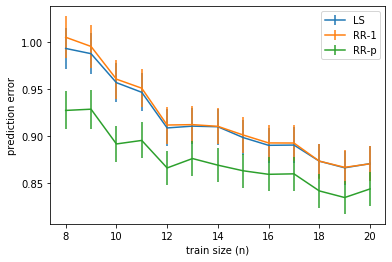

In [9]:
mpl.rc("savefig", dpi=300)

fig = plt.figure()

for model_name, simulation in simulation_results.items():
    plt.errorbar(train_sizes, simulation['mean'], yerr=simulation['error_bar'], label=model_name)
    
plt.legend(loc='upper right')
plt.xlabel('train size (n)')
plt.ylabel('prediction error')
plt.show()